In [1]:
import cmocean as cm
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

figdir = '/home/561/jn8053/g_e14/figures-tmp/easterlies-collaborative/'

In [2]:
session = cc.database.create_session()
experiment_ryf = '01deg_jra55v13_ryf9091'

# Control SWMT map

In [4]:
start_time='2150-01-01'
end_time='2159-12-31'
time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

# stitch together west and east sections:
outpath = '/g/data/v45/akm157/model_data/access-om2/'+experiment_ryf+'/SWMT/west_shelf_transformation_sigma0_'+time_period+'_finer_bins.nc'
output = xr.open_dataset(outpath)
net_transformation_control_west = output.net_transformation_control
outpath = '/g/data/v45/akm157/model_data/access-om2/'+experiment_ryf+'/SWMT/east_shelf_transformation_sigma0_'+time_period+'_finer_bins.nc'
output = xr.open_dataset(outpath)
net_transformation_control_east = output.net_transformation_control
net_transformation_control = xr.concat([net_transformation_control_west,net_transformation_control_east],dim='xt_ocean').mean('year')

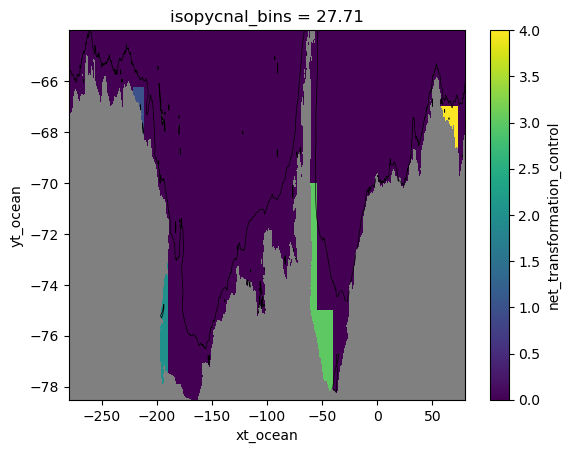

In [5]:
# topography data:
ht = cc.querying.getvar(experiment_ryf,'ht' , session,n=1)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)

# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90
fontsize=16

# set up empty masks:
Ross_mask = net_transformation_control[0,...]*0+1
Ross_mask = Ross_mask.fillna(1)

Adelie_mask = Ross_mask.copy()
Weddell_mask = Ross_mask.copy()
Prydz_mask = Ross_mask.copy()
yt_ocean = Ross_mask.yt_ocean
xt_ocean = Ross_mask.xt_ocean

# set regions:
Ross_mask = Ross_mask.where(yt_ocean<-72).where(yt_ocean>-79).where(xt_ocean>161.5-360).where(xt_ocean<170-360)
Prydz_mask = Prydz_mask.where(yt_ocean<-67).where(yt_ocean>-69).where(xt_ocean>58).where(xt_ocean<73)
Adelie_mask = Adelie_mask.where(yt_ocean<-66.2).where(yt_ocean>-69).where(xt_ocean>138-360).where(xt_ocean<148-360)

# two area to include for this one:
Weddell_maskW = Weddell_mask.where(yt_ocean<-70).where(yt_ocean>-79).where(xt_ocean>297-360).where(xt_ocean<305-360)
Weddell_maskE = Weddell_mask.where(yt_ocean<-75).where(yt_ocean>-79).where(xt_ocean>305-360).where(xt_ocean<320-360)
Weddell_mask = Weddell_maskE.fillna(0) + Weddell_maskW.fillna(0)
Weddell_mask = Weddell_mask.where(Weddell_mask == 1)

# combine all masks:
combined_mask = Adelie_mask.fillna(0) + Ross_mask.fillna(0)*2 + Weddell_mask.fillna(0)*3 + Prydz_mask.fillna(0)*4

combined_mask.plot()
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],linewidths=0.5,colors='k')
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')

array([27.83, 28.03, 27.81, 27.79])

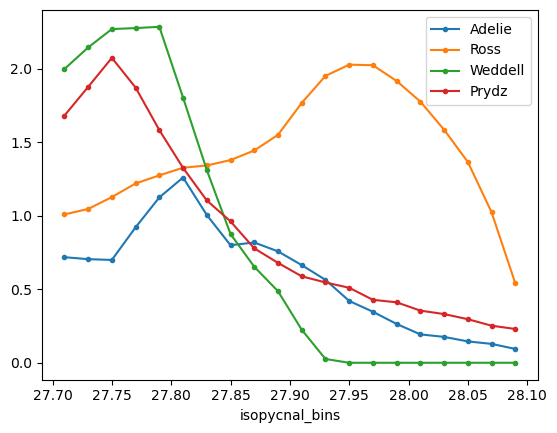

In [6]:
## Find density thresholds to use for each region using a 10 year average of the control:

time_slice = slice(2150,2159)
control_transformation_mean = net_transformation_control

area_t = cc.querying.getvar(experiment_ryf, 'area_t', session, n=1)

regions = ['Adelie','Ross','Weddell','Prydz']
density_threshold = np.zeros(4)

# use density where SWMT is 70% of peak value:
percent_max_SWMT = 0.7

for DSW_region_count in range(4):
    region = regions[DSW_region_count]
    area_mask = area_t.where(combined_mask == DSW_region_count + 1)
    swmt_sum_region = (control_transformation_mean*area_mask).sum(['xt_ocean', 'yt_ocean'])/1e6
    swmt_sum_region.plot(marker='.',label=region)
    # find max value:
    swmt_max = swmt_sum_region.max().values
    # find density where swmt = 0.7*swmt_max:
    density_threshold[DSW_region_count] = swmt_sum_region.where(swmt_sum_region >= swmt_max*percent_max_SWMT,drop=True)[-1].isopycnal_bins.values
    
plt.legend()
    
# TO DO: update SWMT calculation to narrow in on these densities with finer density bins:
density_threshold

In [7]:
iso = xr.open_dataset('~/g_e14/misc/Antarctic_isobath_1000m.nc')

In [27]:
density_threshold

array([27.83, 28.03, 27.81, 27.79])

In [28]:
regions

['Adelie', 'Ross', 'Weddell', 'Prydz']

In [13]:
ht = ht.sel(yt_ocean = slice(-80, -59)) 

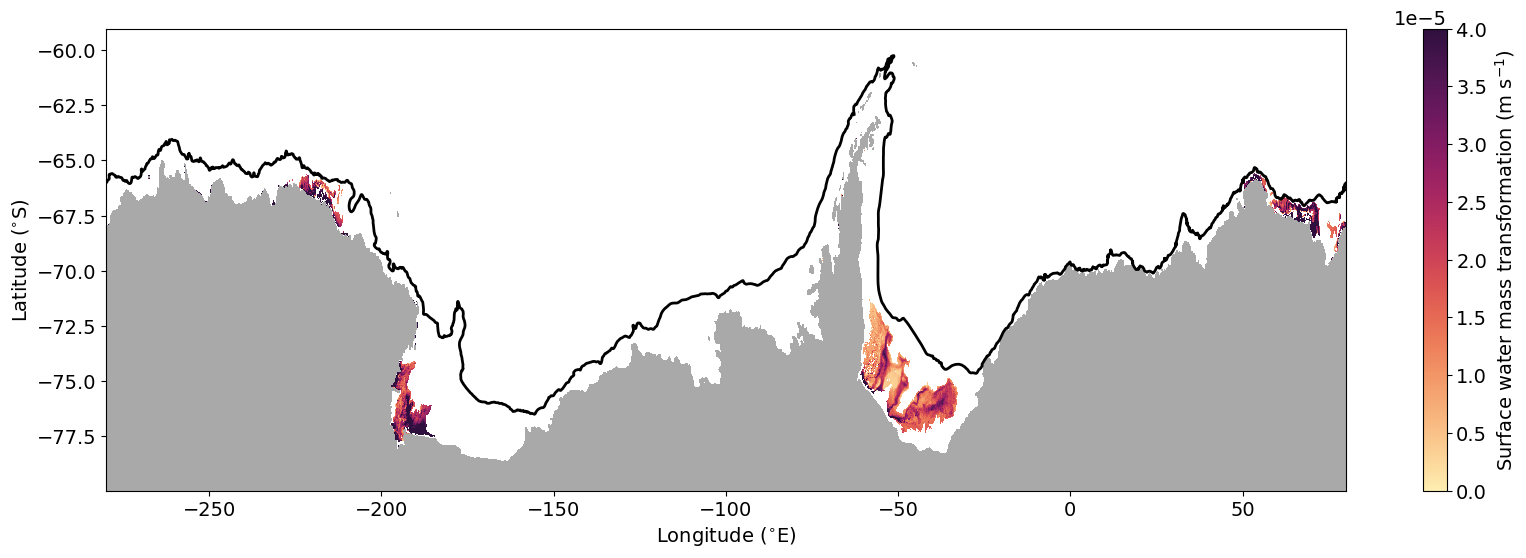

In [45]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (20, 6))
axs = fig.add_subplot()
axs.contourf(ht['xt_ocean'], ht['yt_ocean'], xr.where(np.isnan(ht), 1, np.nan), 
             colors = 'darkgrey', linewidths = 0.5, 
             zorder = 2)
axs.plot(iso['x'], iso['y'], 'k', linewidth = 2, zorder = 2)
# Adelie
axs.pcolormesh(net_transformation_control['xt_ocean'], net_transformation_control['yt_ocean'],
               (net_transformation_control).where(xt_ocean <=-205).sel(isopycnal_bins = density_threshold[0], method = 'nearest').squeeze(),
               vmin = 0, vmax = 4e-5, cmap = cm.cm.matter)
# Ross
axs.pcolormesh(net_transformation_control['xt_ocean'], net_transformation_control['yt_ocean'],
               (net_transformation_control).where((xt_ocean >-210) & (xt_ocean<-100)).sel(isopycnal_bins = density_threshold[1], method = 'nearest').squeeze(),
               vmin = 0, vmax = 4e-5, cmap = cm.cm.matter)
# Weddell
axs.pcolormesh(net_transformation_control['xt_ocean'], net_transformation_control['yt_ocean'],
               (net_transformation_control).where((xt_ocean <-20) & (xt_ocean>-100)).sel(isopycnal_bins = density_threshold[2], method = 'nearest').squeeze(),
               vmin = 0, vmax = 4e-5, cmap = cm.cm.matter)
# Prydz
c = axs.pcolormesh(net_transformation_control['xt_ocean'], net_transformation_control['yt_ocean'],
                   (net_transformation_control).where((xt_ocean> 50)).sel(isopycnal_bins = density_threshold[3], method = 'nearest').squeeze(),
                   vmin = 0, vmax = 4e-5, cmap = cm.cm.matter)
plt.colorbar(c, orientation = 'vertical').set_label('Surface water mass transformation (m s$^{-1}$)')
plt.xlabel('Longitude ($^{\circ}$E)')
plt.ylabel('Latitude ($^{\circ}$S)')
plt.savefig('swmt_map.jpg', bbox_inches = 'tight')